# Step 3 -  Machine Learning Models
       Previsão da avaliação que um usuário daria a um filme que ainda não avaliou.

In [79]:
import pandas as pd
import numpy as np

from scipy import sparse
import os
from sklearn.metrics.pairwise import cosine_similarity

from datetime import datetime
import random

import xgboost as xgb

import matplotlib
import matplotlib.pyplot as plt

###### Função para extrair amostras de dados das matrizes esparsas criadas no step 2

In [89]:
# Função para obter amostra da matriz esparsa
def gera_amostra_matriz_esparsa(sparse_matrix, num_users, num_movies, path, verbose = True):

    # Tupla: (row, col) e (rating) da matriz esparsa
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    # Random seed para reproduzir o processo aleatório
    np.random.seed(15)
    
    # Amostras de usuários e filmes
    sample_users = np.random.choice(users, num_users, replace = True)
    sample_movies = np.random.choice(movies, num_movies, replace = True)
    
    # Gera a máscara booleana
    mask = np.logical_and(np.isin(row_ind, sample_users), np.isin(col_ind, sample_movies))
    
    # Matriz esparsa com as amostras da matriz original
    amostra_matriz_esparsa = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])), 
                                               shape = (max(sample_users) + 1, max(sample_movies) + 1))
    
    # Salva em disco
    print('Salvando em disco...')
    sparse.save_npz(path, amostra_matriz_esparsa)
    
    if verbose:
            print('Tarefa concluída.\n')
    
    return amostra_matriz_esparsa

#### Gerando Amostra de Dados de Treino

In [94]:
%%time

# matriz esparsa de treino gerada no step 2
caminho_matriz_treino_original = "archive/matriz_esparsa_treino.npz"

matriz_esparsa_treino_loaded = sparse.load_npz(caminho_matriz_treino_original)

# Onde salvar a amostra
path = 'archive/amostra_matriz_esparsa_treino.npz'

# Obtemos avaliações de 10000 usuários a 1000 filmes na matriz esparsa de treino
amostra_matriz_esparsa_treino = gera_amostra_matriz_esparsa(matriz_esparsa_treino_loaded, 
                                                            num_users = 10000, #define tamanho da amostra
                                                            num_movies = 1000, 
                                                            path = path)

Salvando em disco...
Tarefa concluída.

Wall time: 1min 8s


#### Gerando Amostra de Dados de Teste

In [95]:
%%time

# matriz esparsa de treino gerada no step 2
caminho_matriz_teste_original = "archive/matriz_esparsa_teste.npz"

matriz_esparsa_teste_loaded = sparse.load_npz(caminho_matriz_teste_original)

path = 'archive/amostra_matriz_esparsa_teste.npz'

# Obtemos avaliações de 400 usuários a 40 filmes na matriz esparsa de treino
amostra_matriz_esparsa_teste = gera_amostra_matriz_esparsa(matriz_esparsa_teste_loaded, 
                                                           num_users = 400, 
                                                           num_movies = 40,
                                                           path = path)

Salvando em disco...
Tarefa concluída.

Wall time: 16.3 s


In [97]:
# Resumo
print('Número de avaliações na matriz com amostras de treino: {}'.format(amostra_matriz_esparsa_treino.count_nonzero()))
print('Número de avaliações na matriz com amostras de teste: {}'.format(amostra_matriz_esparsa_teste.count_nonzero()))

Número de avaliações na matriz com amostras de treino: 112832
Número de avaliações na matriz com amostras de teste: 169


### Métricas Extraídas dos Dados

Vamos verificar algumas métricas a partir dos dados. Nosso modelo vai prever a avaliação do usuário ao filme.

In [98]:
# Cria o dicionário para guardar análises
amostra_medias_treino = dict()

A função abaixo será usada para calcular a média de avaliações.

In [99]:
def calcula_media_avaliacoes(sparse_matrix, of_users):
    '''
    Se parâmetro "of_users" == True, o cálculo vai ser por usuários. Se False, por filme.
    '''
    
    # Média de avaliações
    # 1 representa o eixo de usuários
    # 0 representa o eixo de filmes
    ax = 1 if of_users else 0 

    # Soma das avaliações
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    
    # Matriz booleana de avaliações (se um usuário avaliou ou não um filme)
    is_rated = sparse_matrix != 0
    
    # Número de avaliações de cada usuário ou filme
    no_of_ratings = is_rated.sum(axis = ax).A1
    
    # Ids da matriz esparsa, u de usuário e m de movie
    u,m = sparse_matrix.shape
    
    # Dicionário de usuários e suas avaliações
    media_avaliacoes = {i:sum_of_ratings[i] / no_of_ratings[i] 
                       for i in range(u if of_users else m) 
                       if no_of_ratings[i] != 0}

    return media_avaliacoes

In [100]:
print(amostra_matriz_esparsa_treino)

  (301, 2699)	4
  (301, 3608)	5
  (301, 4310)	2
  (301, 4996)	5
  (301, 5047)	3
  (301, 5496)	5
  (301, 6034)	3
  (301, 6337)	3
  (301, 8881)	4
  (301, 10275)	4
  (301, 11022)	1
  (301, 14109)	4
  (301, 15183)	5
  (301, 16293)	3
  (462, 191)	2
  (462, 1307)	2
  (462, 1703)	3
  (462, 2209)	5
  (462, 2699)	2
  (462, 2874)	2
  (462, 3526)	3
  (462, 3756)	3
  (462, 4914)	2
  (462, 5496)	2
  (462, 5601)	3
  :	:
  (2649097, 978)	5
  (2649097, 3611)	3
  (2649097, 3756)	2
  (2649097, 5516)	3
  (2649097, 5662)	5
  (2649097, 9048)	3
  (2649097, 9170)	5
  (2649097, 10729)	5
  (2649097, 11022)	1
  (2649097, 11820)	1
  (2649097, 13856)	5
  (2649097, 16740)	3
  (2649375, 191)	4
  (2649375, 1307)	3
  (2649375, 3427)	4
  (2649375, 3756)	3
  (2649375, 11443)	5
  (2649375, 12161)	4
  (2649375, 14240)	4
  (2649375, 14456)	3
  (2649375, 14550)	5
  (2649375, 14855)	4
  (2649375, 15424)	5
  (2649375, 16068)	4
  (2649375, 16452)	5


Média global das avaliações dos filmes:

In [101]:
# Guardando média global no dicionário
media_global = amostra_matriz_esparsa_treino.sum() / amostra_matriz_esparsa_treino.count_nonzero()
amostra_medias_treino['global'] = media_global
amostra_medias_treino

{'global': 3.596151800907544}

Média de avaliação por usuário:

In [102]:
# Calcula a média de avaliação dos usuários
amostra_medias_treino['usuario'] = calcula_media_avaliacoes(amostra_matriz_esparsa_treino, of_users = True) 

In [103]:
# Vamos extrair um dos usuários do dicionário de filmes (o objetivo aqui é apenas automatizar o processo)
um_usuario = [a for a, b in amostra_medias_treino['usuario'].items()][0]
um_usuario

301

In [104]:
# Print
print('Média de Avaliação do Usuário ' + str(um_usuario) + ':', amostra_medias_treino['usuario'][um_usuario])

Média de Avaliação do Usuário 301: 3.642857142857143


Média de avaliação por filme:

In [105]:
# Calcula a média de avaliação dos filmes
amostra_medias_treino['filme'] =  calcula_media_ratings(amostra_matriz_esparsa_treino, of_users = False)

In [106]:
# Vamos extrair um dos filmes do dicionário de filmes (o objetivo aqui é apenas automatizar o processo)
um_filme = [a for a, b in amostra_medias_treino['filme'].items()][0]
um_filme

7

In [107]:
print('Média de Avaliação do Filme ' + str(um_filme) + ':', amostra_medias_treino['filme'][um_filme])

Média de Avaliação do Filme 7: 1.0


## Variáveis utilizadas na implementação do modelo:

### Inputs:

- **GAvg** : Média global das avaliações


- **Avaliação de usuários semelhantes**:
    - sur1, sur2, sur3, sur4, sur5 (5 principais usuários similares a cada usuário que avaliou um filme)
    

- **Filmes semelhantes avaliados por um usuário**:
    - smr1, smr2, smr3, smr4, smr5 (5 principais filmes similares a cada filme avaliado)


- **UAvg** : Média de avaliações dos usuários


- **MAvg** : Média de avaliação do filme


### Output: 

- **avaliação** : Avaliação do filme dada por um usuário

### Preparando os Dados de Treino Para o Modelo de Regressão

In [108]:
amostra_matriz_esparsa_treino

<2649376x17673 sparse matrix of type '<class 'numpy.int64'>'
	with 112832 stored elements in Compressed Sparse Row format>

In [109]:
# Extraindo os dados da matriz de amostras
amostra_usuarios_treino, amostra_filmes_treino, amostra_avaliacoes_treino = sparse.find(amostra_matriz_esparsa_treino)

In [110]:
amostra_usuarios_treino

array([ 919153, 1901461, 2105602, ..., 2633797, 2642973, 2646207],
      dtype=int32)

In [111]:
amostra_filmes_treino

array([    7,     7,     7, ..., 17672, 17672, 17672], dtype=int32)

In [112]:
len(amostra_avaliacoes_treino)

112832

##### Na criação da amostra foi definido avaliações de 10000 usuários a 1000 filmes na matriz esparsa de treino. Então essa etapa demora um pouco pra rodar

In [ ]:
%%time
start = datetime.now()
# Verificamos se o arquivo já existe
if os.path.isfile('archive/dados_treino_reg.csv'):
    print("O arquivo já existe e não precisamos criar movamente..." )
else:
    print('Preparando {} tuplas para o dataset..\n'.format(len(amostra_medias_treino)))
    with open('archive/dados_treino_reg.csv', mode = 'w') as reg_data_file:
        count = 0
        for (usuario, filme, avaliacao) in zip(amostra_usuarios_treino, amostra_filmes_treino, amostra_avaliacoes_treino):
             
            ###### Avaliação de um "filme" por usuários similares ao usuário corrente ######
            
            # Calcula usuário similar ao usuário corrente        
            user_sim = cosine_similarity(amostra_matriz_esparsa_treino[usuario], 
                                         amostra_matriz_esparsa_treino).ravel()
            
            # Obtém top users
            top_sim_users = user_sim.argsort()[::-1][1:] 
            
            # Obtém avaliações de usuários similares 
            top_ratings = amostra_matriz_esparsa_treino[top_sim_users, filme].toarray().ravel()
            
            # Top usuários similares até 5
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([amostra_medias_treino['filme'][filme]]*(5 - len(top_sim_users_ratings))) 

            ##### Avaliações por usuário para filmes similares ao filme corrente #####
            
            # Calcula filmes similares ao filme corrente       
            movie_sim = cosine_similarity(amostra_matriz_esparsa_treino[:,filme].T, 
                                          amostra_matriz_esparsa_treino.T).ravel()
            
            # Top filmes
            top_sim_movies = movie_sim.argsort()[::-1][1:] 
            
            # Obtém avaliações do filme mais similar para o usuário corrente
            top_ratings = amostra_matriz_esparsa_treino[usuario, top_sim_movies].toarray().ravel()
            
            # Top usuários similares até 5
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([amostra_medias_treino['usuario'][usuario]] * (5-len(top_sim_movies_ratings))) 

            ##### Prepara a linha que será armazenada no arquivo #####
            row = list()
            row.append(usuario)
            row.append(filme)
            
            # Adicionamos outros atributos 
            row.append(amostra_medias_treino['global']) 
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            row.append(amostra_medias_treino['usuario'][usuario])
            row.append(amostra_medias_treino['filme'][filme])

            row.append(avaliacao)
            count = count + 1
            
            #if count == 10:
            #    break

            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                print("Concluído para {} linhas----- {}".format(count, datetime.now() - start))

In [118]:
df_dados_treino_reg = pd.read_csv('archive/dados_treino_reg.csv', 
                                  names = ['usuario', 'filme', 
                                           'GAvg', 
                                           'sur1','sur2','sur3', 'sur4', 'sur5',
                                           'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                           'UAvg','MAvg', 
                                           'avaliacao'],
                                  header = None)

In [119]:
df_dados_treino_reg.head()

,usuario,filme,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,avaliacao
0,919153,7,3.596152,1.0,1.0,1.0,1.0,1.0,4.0,3.0,2.0,5.0,2.0,2.714286,1.0,1
1,1901461,7,3.596152,1.0,1.0,1.0,1.0,1.0,3.0,5.0,5.0,5.0,5.0,3.545455,1.0,1
2,2105602,7,3.596152,1.0,1.0,1.0,1.0,1.0,1.0,5.0,4.0,4.0,3.0,3.548780,1.0,1
3,1773304,10,3.596152,1.0,2.0,2.0,2.0,2.0,4.0,5.0,3.0,4.0,4.0,3.593750,2.0,3
4,2291127,10,3.596152,3.0,2.0,2.0,2.0,2.0,1.0,2.0,4.0,4.0,4.0,3.307692,2.0,1


In [120]:
df_dados_treino_reg.shape

(10000, 16)

In [116]:
df_dados_treino_reg.shape

(1010, 16)

### Mesma coisa pra Teste

Roda um mais rápido pq a amostra é menor q a de treino, 400 usuários a 40 filmes na matriz esparsa de teste

In [121]:
amostra_matriz_esparsa_teste

<2647099x17593 sparse matrix of type '<class 'numpy.int64'>'
	with 169 stored elements in Compressed Sparse Row format>

In [122]:
# Extraindo os dados da matriz de amostras
amostra_usuarios_teste, amostra_filmes_teste, amostra_avaliacoes_teste = sparse.find(amostra_matriz_esparsa_teste)

In [123]:
%%time
start = datetime.now()
if os.path.isfile('archive/dados_teste_reg.csv'):
    print("O arquivo já existe e não precisamos criar movamente...")
else:

    print('Preparando {} tuplas para o dataset..\n'.format(len(amostra_avaliacoes_teste)))
    with open('archive/dados_teste_reg.csv', mode='w') as reg_data_file:
        count = 0 
        for (usuario, filme, avaliacao)  in zip(amostra_usuarios_teste, amostra_filmes_teste, amostra_avaliacoes_teste):
            st = datetime.now()

            # Similaridade de usuários
            try:
                user_sim = cosine_similarity(amostra_matriz_esparsa_treino[usuario], 
                                             amostra_matriz_esparsa_treino).ravel()
                
                top_sim_users = user_sim.argsort()[::-1][1:] 
                top_ratings = amostra_matriz_esparsa_treino[top_sim_users, filme].toarray().ravel()
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([amostra_medias_treino['filme'][filme]]*(5 - len(top_sim_users_ratings)))

            except (IndexError, KeyError):
                top_sim_users_ratings.extend([amostra_medias_treino['global']]*(5 - len(top_sim_users_ratings)))
            except:
                print(usuario, filme)
                raise

            # Similaridade de filmes
            try:
                movie_sim = cosine_similarity(amostra_matriz_esparsa_treino[:,filme].T, 
                                              amostra_matriz_esparsa_treino.T).ravel()
                
                top_sim_movies = movie_sim.argsort()[::-1][1:] 
                top_ratings = amostra_matriz_esparsa_treino[usuario, top_sim_movies].toarray().ravel()
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([amostra_medias_treino['usuario'][usuario]]*(5-len(top_sim_movies_ratings))) 
            except (IndexError, KeyError):
                top_sim_movies_ratings.extend([amostra_medias_treino['global']]*(5-len(top_sim_movies_ratings)))
            except :
                raise

            # Prepara os dados para gravar no arquivo
            row = list()
            row.append(usuario)
            row.append(filme)
            row.append(amostra_medias_treino['global']) 
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)

            try:
                row.append(amostra_medias_treino['usuario'][usuario])
            except KeyError:
                row.append(amostra_medias_treino['global'])
            except:
                raise

            try:
                row.append(amostra_medias_treino['filme'][filme])
            except KeyError:
                row.append(amostra_medias_treino['global'])
            except:
                raise

            row.append(avaliacao)
            
            count = count + 1
            
            #if count == 5:
            #    break
    
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                print("Concluído em {} linhas----- {}".format(count, datetime.now() - start))

Preparando 169 tuplas para o dataset..

Wall time: 46.9 s


In [124]:
# Gera o dataset de teste
df_dados_teste_reg = pd.read_csv('archive/dados_teste_reg.csv', names = ['usuario', 'filme', 
                                                                       'GAvg', 
                                                                       'sur1','sur2','sur3', 'sur4', 'sur5',
                                                                       'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                                       'UAvg','MAvg', 
                                                                       'avaliacao'],
                                 header = None)

In [125]:
df_dados_teste_reg.head()

,usuario,filme,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,avaliacao
0,95062,607,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,4
1,214729,607,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,4
2,253859,607,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,2
3,271420,607,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,4
4,381954,607,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,3.596152,5


In [127]:
df_dados_teste_reg.shape

(169, 16)

In [128]:
len(df_dados_treino_reg.columns)

16

In [129]:
len(df_dados_teste_reg.columns)

16

### Modelo

In [130]:
# Dicionários para avaliação do modelo
models_evaluation_train = dict()
models_evaluation_test = dict()

In [131]:
# Função para o cálculo do erro do modelo
def calcula_metricas(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

In [132]:
# Função para treino e teste do modelo
def executa_modelo_xgboost(modelo, x_train, y_train, x_test, y_test, verbose = True):

    # Dicionários
    train_results = dict()
    test_results = dict()
    
    # Treinamento do modelo
    print('Treinando o modelo..')
    start = datetime.now()
    modelo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Concluído. Tempo total: {}\n'.format(datetime.now() - start))

    # Calculando o erro do modelo nos dados de treino
    print('Calculando as Métricas com Dados de Treino.')
    start = datetime.now()
    y_train_pred = modelo.predict(x_train)
    rmse_train, mape_train = calcula_metricas(y_train.values, y_train_pred)
    
    # Grava os resultados
    train_results = {'rmse': rmse_train, 'mape' : mape_train, 'previsoes' : y_train_pred}
    
    if verbose:
        print('\nErro do Modelo em Dados de Treino')
        print('-'*30)
        print('RMSE : ', rmse_train)
        print('MAPE : ', mape_train)
        
    # Avaliando o modelo com dados de teste
    print('\nAvaliando o modelo com dados de teste.')
    y_test_pred = modelo.predict(x_test) 
    rmse_test, mape_test = calcula_metricas(y_true = y_test.values, y_pred = y_test_pred)
    
    # Grava os resultados
    test_results = {'rmse': rmse_test, 'mape' : mape_test, 'previsoes':y_test_pred}
    
    if verbose:
        print('\nErro do Modelo em Dados de Teste')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    return train_results, test_results

In [133]:
# Seed
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

In [134]:
# Prepara os dados de treino
x_treino = df_dados_treino_reg.drop(['usuario', 'filme', 'avaliacao'], axis = 1)
y_treino = df_dados_treino_reg['avaliacao']

In [135]:
# Prepara os dados de teste
x_teste = df_dados_teste_reg.drop(['usuario', 'filme', 'avaliacao'], axis = 1)
y_teste = df_dados_teste_reg['avaliacao']

In [136]:
# Cria o modelo de regressão com 100 estimadores
modelo_xgb = xgb.XGBRegressor(silent = False, random_state = 15, n_estimators = 100)

In [137]:
# Treinamento do modelo
train_results, test_results = executa_modelo_xgboost(modelo_xgb, x_treino, y_treino, x_teste, y_teste)

Treinando o modelo..
[15:53:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Concluído. Tempo total: 0:00:00.442294

Calculando as Métricas com Dados de Treino.

Erro do Modelo em Dados de Treino
------------------------------
RMSE :  0.8078431990765995
MAPE :  23.950102057337762

Avaliando o modelo com dados de teste.

Erro do Modelo em Dados de Teste
------------------------------
RMSE :  1.1081779366885551
MAPE :  33.226036360042805


In [138]:
# Armazena os resultados da avaliação do modelo
models_evaluation_train['modelo_xgb'] = train_results
models_evaluation_test['modelo_xgb'] = test_results

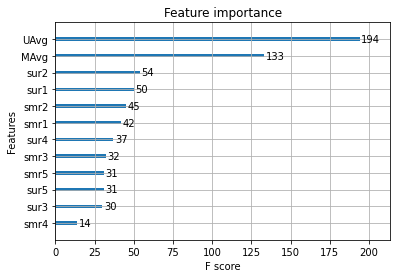

In [139]:
# Variáveis mais importantes para o modelo
xgb.plot_importance(modelo_xgb)
plt.show()

In [140]:
models_evaluation_test

{'modelo_xgb': {'mape': 33.226036360042805,
  'previsoes': array([3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212,
         3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212,
         3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212,
         3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212,
         3.0902722, 3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212,
         3.5995212, 3.7185678, 3.5995212, 3.5995212, 3.5995212, 3.5995212,
         3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212,
         3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212,
         3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212,
         3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212,
         3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212,
         3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212, 3.5995212,
         3.5995212, 3.5995212, 3.5995212, 3

In [141]:
result = pd.DataFrame(models_evaluation_test)

In [142]:
result.loc['rmse'].sort_values()

modelo_xgb    1.10818
Name: rmse, dtype: object